In [1]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [2]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [3]:
# Selected Features
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']

# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.shape

(3619, 30)

# Load models

In [4]:
# Decision Tree
decision_tree = DecisionTreeRegressor(**load_params('decision_tree_params.json'))

# Bagging
bagging = BaggingRegressor(**load_params('bagging_params.json'))

# Random Forest
random_forest = RandomForestRegressor(**load_params('random_forest_params.json'))

# Extremely randomized tree
extra_forest = ExtraTreesRegressor(**load_params('extremely_randomized_forest_params.json'))

# Adaboost
adaboost = AdaBoostRegressor(**load_params('adaboost_params.json'))

# sklearn gradient boosting
sk_gb = GradientBoostingRegressor(**load_params('sk_gradient_boosting_params.json'))

# sklearn hist gradient boosting
hist_sk_gb = HistGradientBoostingRegressor(**load_params('sk_hist_gradient_boosting_params.json'))

# evaluation sets for early stopping
evaluation = [( X_train_np, y_train_np), ( X_val_np, y_val_np)]

# lgbm
lgbm = LGBMRegressor(**load_params('lgbm_params.json'))

# XGBOOST
xgb = xg.XGBRegressor(**load_params('xgb_params.json'))

In [15]:
def stacking_prediction(estimators,X_train_np,y_train_np,X_test_np, cv = 5):
    '''
    compute predictions and make an average
    
    INPUTS:
        estimators : list of tuples containing a (string,model)
        X_train_np : training feature matrix as numpy array
        y_train_np : y labels for training
        X_test_np  : test feature matrix as numpy array
        
    OUTPUTS:
        y_pred : predicted labels
    '''
    
    cv_idx = np.random.choice(np.arange(cv),size = X_train.shape[0])
    n_estimators = len(estimators)
    
    X_meta = np.zeros((X_train.shape[0],n_estimators))
    for i in range(cv):
        X_cv_train = X_train_np[cv_idx!=i,:]
        y_cv_train = y_train_np[cv_idx!=i]
        X_cv_val =  X_train_np[cv_idx==i,:]
        
        for j in range(n_estimators):
                X_meta[cv_idx==i,j] = np.maximum(0,estimators[j][1].fit(X_cv_train, y_cv_train).predict(X_cv_val))
    
    X_meta = np.concatenate((X_train_np,X_meta),axis=1)
    
    X_meta_test = np.zeros((X_test.shape[0],n_estimators))
    for j in range(n_estimators):
        X_meta_test[:,j] = np.maximum(0,estimators[j][1].fit(X_train_np, y_train_np).predict(X_test_np))

        
    X_meta_test = np.concatenate((X_test_np,X_meta_test),axis=1)

    
    from sklearn.linear_model import LinearRegression            
    y_pred = LinearRegression().fit(X_meta,y_train_np).predict(X_meta_test)
    
    return y_pred
    
    

import time
start = time.time()
estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]
estimators = [ ('lgbm', lgbm),('extra_forest', extra_forest)]
y_pred = stacking_prediction(estimators,X_train_np,y_train_np,X_test_np)
print(time.time()-start)

120.02909016609192


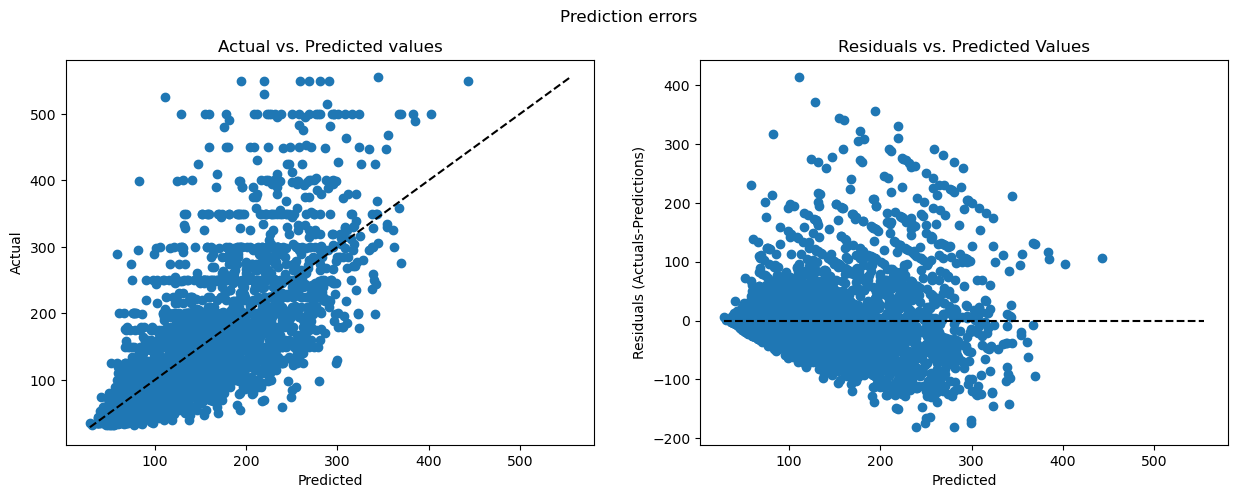

R²: 0.5736906084051212
MAE: 40.31691761549153
MSE: 3813.8756524397922
RMSE: 61.75658387929009
MAPE: 0.3112613047342765
error_ratio_rmse: 0.4465101371296531
error_ratio_mae: 0.2914978660141683


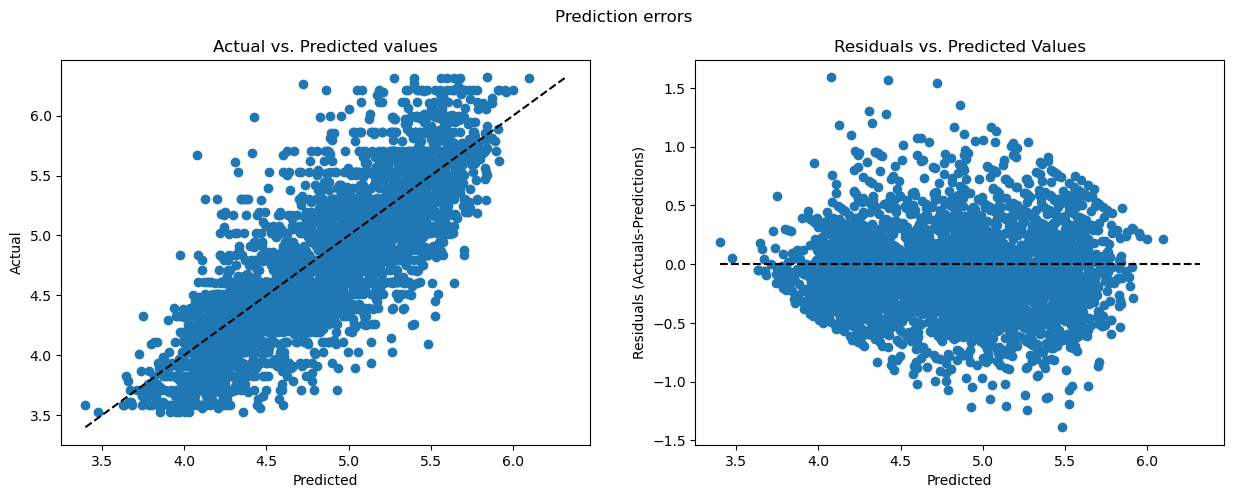

R²: 0.6634668581771892
MAE: 0.28077540612756297
MSE: 0.13078700197142748
RMSE: 0.36164485613848774
MAPE: 0.06029310877879079
error_ratio_rmse: 0.07632654094375313
error_ratio_mae: 0.05925873178626863


In [16]:
# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

130.07501769065857


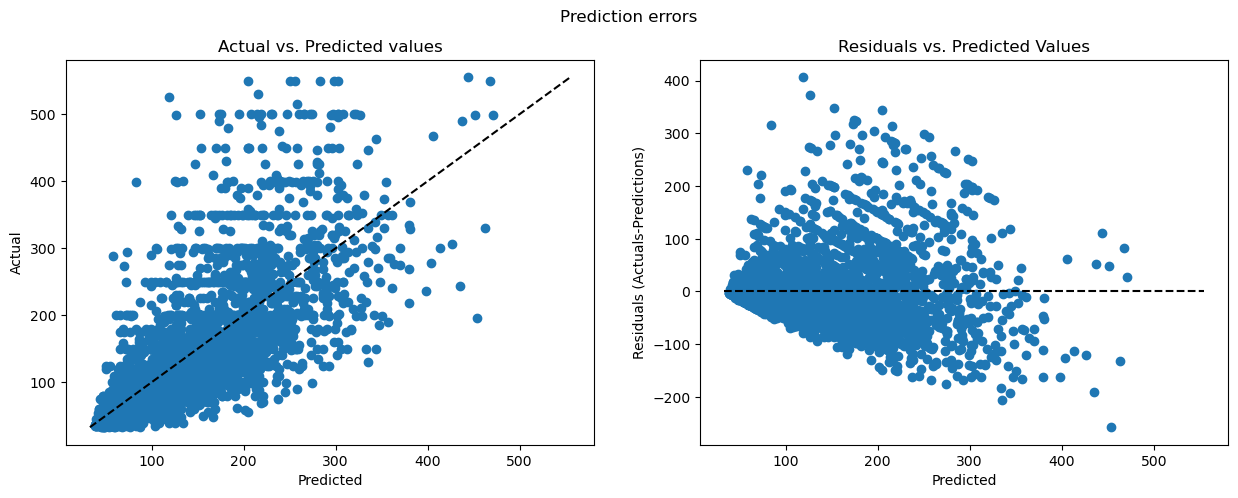

R²: 0.5512662005489439
MAE: 41.30796147894879
MSE: 4014.490287794407
RMSE: 63.36000542767027
MAPE: 0.31576682644079634
error_ratio_rmse: 0.45810313548660997
error_ratio_mae: 0.2986632741954035


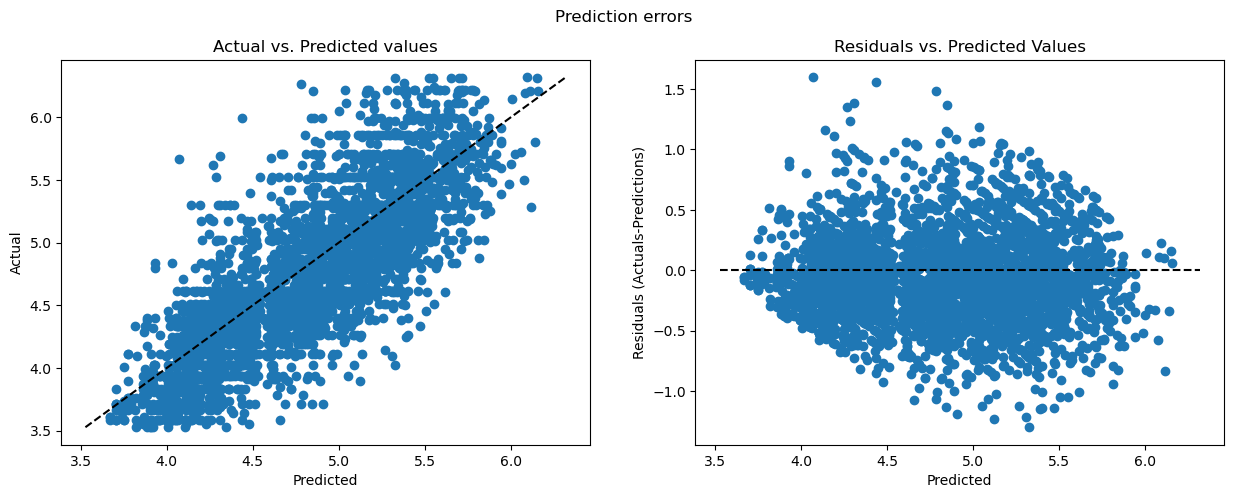

R²: 0.653888258544785
MAE: 0.28533854572642564
MSE: 0.13450953676316085
RMSE: 0.36675541817832885
MAPE: 0.061137893876716996
error_ratio_rmse: 0.07740514476227434
error_ratio_mae: 0.060221799988436776


In [17]:
start = time.time()

estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]
estimators = [ ('lgbm', lgbm),('extra_forest', extra_forest)]

stacking = StackingRegressor(estimators=estimators, final_estimator = xg.XGBRegressor()).fit(X_train_np, y_train_np)

y_pred = np.maximum(0,stacking.predict(X_test_np))

print(time.time()-start)

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

#### Model Tuning

In [ ]:
space = {
    'w1': hp.uniform('w1', 0, 1),
    'w2': hp.uniform('w2', 0, 1),
    'w3': hp.uniform('w3', 0, 1),
    'w4': hp.uniform('w4', 0, 1),
    'w5': hp.uniform('w5', 0, 1),
    'w6': hp.uniform('w6', 0, 1),
    'w7': hp.uniform('w7', 0, 1),
    'w8': hp.uniform('w8', 0, 1),
    'w9': hp.uniform('w9', 0, 1)

}


def objective(weights):
    # Normalize the weights to sum to 1
    weights_normalized = [w/sum(weights.values()) for w in weights.values()]
    
    estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]
    y_pred = vote_prediction(estimators,X_train_np,y_train_np,X_test_np, weights_normalized)
    
    score = scores(y_test_np, y_pred)['RMSE']
    print ("SCORE:", score)

    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

In [7]:
best_hyperparams

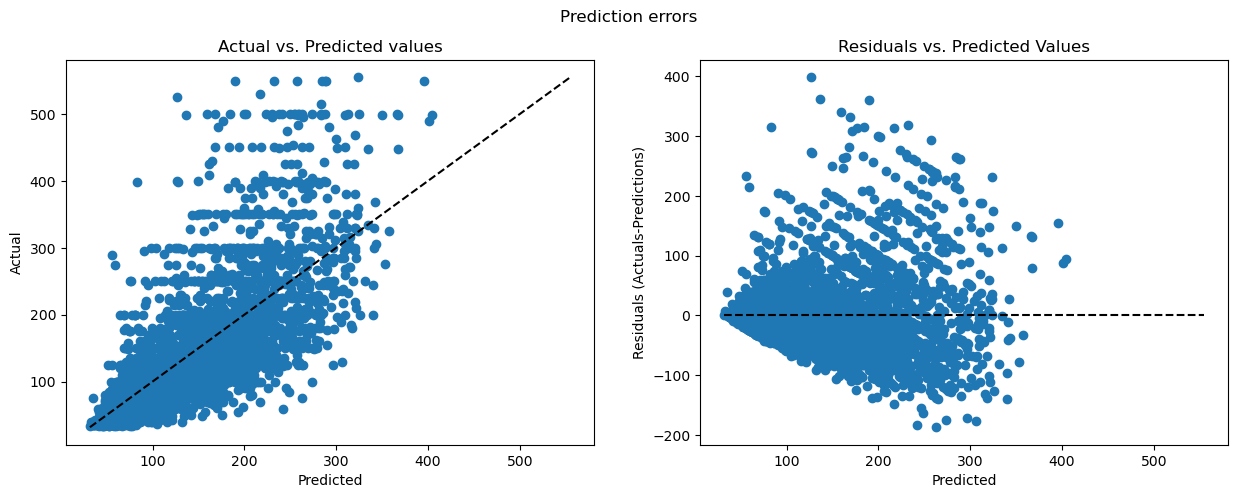

R²: 0.5696644301591596
MAE: 40.734094053712724
MSE: 3849.8948992295705
RMSE: 62.047521298030674
MAPE: 0.3151273303182873
error_ratio_rmse: 0.448613661945597
error_ratio_mae: 0.29451411945528316


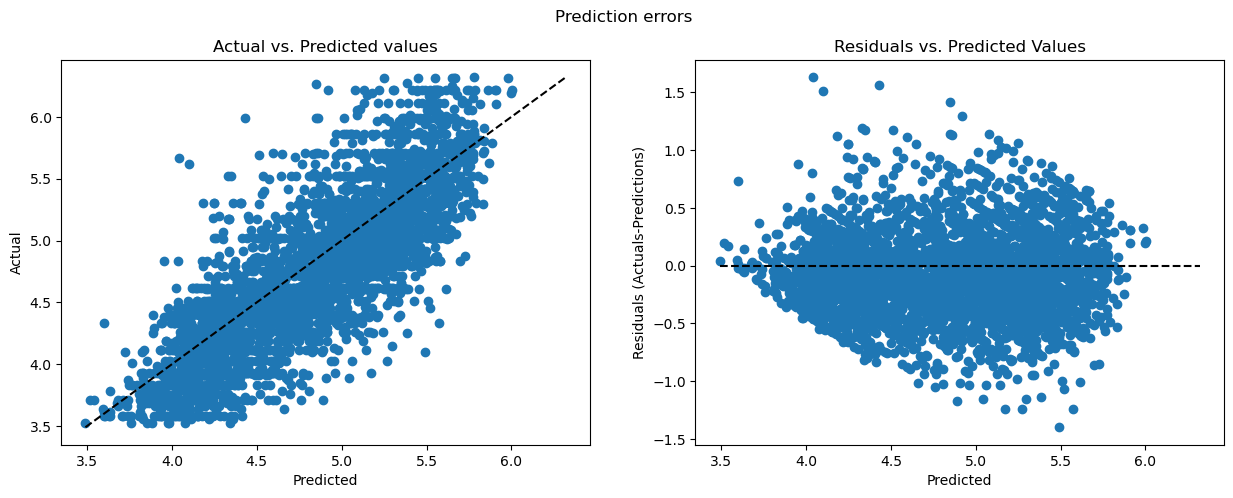

R²: 0.6597966149030239
MAE: 0.28375923851247276
MSE: 0.1322133700008402
RMSE: 0.3636115647237313
MAPE: 0.060944394068103036
error_ratio_rmse: 0.07674162237186707
error_ratio_mae: 0.05988848111307476


In [8]:
model_tuned = xg.XGBRegressor(
                          n_estimators =int(best_hyperparams['n_estimators']), 
                          max_depth = int(best_hyperparams['max_depth']), 
                          gamma = best_hyperparams['gamma'],
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=best_hyperparams['colsample_bytree'],
                          colsample_bylevel=best_hyperparams['colsample_bylevel'],
                          colsample_bynode=best_hyperparams['colsample_bynode'],
                          subsample=best_hyperparams['subsample'],
                          learning_rate=best_hyperparams['learning_rate'],
                          seed = int(best_hyperparams['seed']),
                          objective = 'reg:squarederror',
                          eval_metric = 'rmse'
                       )

evaluation = [( X_train_np, y_train_np), ( X_val_np, y_val_np)]

model_tuned.set_params(early_stopping_rounds=10)
model_tuned.fit(X_train_np, y_train_np,eval_set=evaluation,verbose=False)

y_pred = np.maximum(0,model_tuned.predict(X_test_np))
model_tuned_score = scores(y_test_np,y_pred,plot=True)
model_tuned_logscore= scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

In [10]:
# save model to JSON and load it
model_tuned.save_model("saved_models/xgb_model.json")

# To load model
# xgb_2 = XGBRegressor()
# xgb_2.load_model("model.json")